In [1]:
from core.utils import * 
from core.datasetclass import LinearElasticityVAEDataset
from core.model_gcvae import GraphConvolutionCVAE
from core.fem_solver import *
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from dolfinx import fem, io, default_scalar_type, mesh
import torch.nn.functional as F
from torch_geometric.data import Data

In [2]:
torch.manual_seed(42) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = LinearElasticityVAEDataset(data_dir = "/home/narupanta/ADDMM/surrogate_model/dataset")
num_nodes = dataset[0].x.shape[0]
print("number of trajectories: ", len(dataset))
_, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = False)

number of trajectories:  900


In [3]:
model_path = "/home/narupanta/ADDMM/ADDMM/surrogate_model/output/2025-02-06T22h18m00s/model_checkpoint"
model = GraphConvolutionCVAE(params_size = 2,
                                 hidden_size = 256,
                                 latent_dim = 256,
                                 input_size = num_nodes, skip = True, 
                                 act = F.elu, conv = 'GMMConv', node_feat_size=2,
                                 edge_feat_size= 1, output_size=2)
model.load_model(model_path)
model.to(device)

GraphConvolutionCVAE(
  (_output_normalizer): Normalizer()
  (_node_features_normalizer): Normalizer()
  (_edge_features_normalizer): Normalizer()
  (_params_normalizer): Normalizer()
  (down_convs): Sequential(
    (0): GMMConv(4, 2, dim=1)
    (1): GMMConv(2, 2, dim=1)
  )
  (mlp_mu): Sequential(
    (0): Linear(in_features=2234, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): Linear(in_features=256, out_features=256, bias=True)
  )
  (mlp_logvar): Sequential(
    (0): Linear(in_features=2234, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): Linear(in_features=256, out_features=256, bias=True)
  )
  (up_convs): Sequential(
    (0): GMMConv(2, 2, dim=1)
    (1): GMMConv(2, 2, dim=1)
  )
  (up_late

In [4]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    loop = tqdm(enumerate(test_loader), total = len(test_loader), leave = False)
    for idx_traj, batch in loop:
        batch.to(device)
        outputs = model(batch, False)
        loss = model.loss_function(outputs, batch, beta = 0)
        test_loss += loss.item()
        loop.set_description(f"Trajectory {idx_traj + 1}/{len(test_loader)}")
        loop.set_postfix({"Test MSE Loss": f"{loss.item():.4f}"})
    print(f"Average Test MSE Loss: {test_loss:.4f}")

Average Test MSE Loss: 0.3525


In [5]:
test_iter = iter(test_loader)

In [6]:
test_sample = next(test_iter)
test_sample = test_sample.to(device)
test_predict = model.predict(test_sample)

In [7]:
def plot_result_compare_FEM(mesh_pos, triangles, predictions, fem_result, material_params) :
    # Get node coordinates
    nodes = mesh_pos  # Extract the x, y coordinates (for 2D)
    predictions_plot = predictions
    fem_result = fem_result
    plotdata = {"Predicted displacement" : predictions_plot, "FEM displacement" : fem_result, "Error field" : np.abs(predictions_plot - fem_result)}
    # Get connectivity for triangular elements
    # normalized_mat_params = data.material_params[0].cpu() 
    # material_parameters = normalized_mat_params * matstd + matmean
    # Plotting
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

    # First subplot
    for key, v in plotdata.items() :
        for j in range(2) :
            i = list(plotdata.keys()).index(key)
            if key != "Error field" :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            else :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
            if j == 0 :
                axes[j][i].set_title(f"{key} X")
            else :
                axes[j][i].set_title(f"{key} Y")
            axes[j][i].set_xlabel("X-coordinate")
            axes[j][i].set_ylabel("Y-coordinate")
            fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")
    # fig.suptitle(f"Prediction vs FEM" , fontsize=16)
    plt.tight_layout()
    pp = PdfPages(f'G{material_params[0]:.2e}Pa_K{material_params[1]:.2e}Pa.pdf')
    pp.savefig(fig)
    pp.close()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def plot_result_compare_FEM(mesh_pos, triangles, predictions, fem_result, material_params):
    # Get node coordinates
    nodes = mesh_pos  
    predictions_plot = predictions
    plotdata = {
        "CGCVAE Predicted displacement": predictions_plot,
        "FEM displacement": fem_result,
        "Error field": np.abs(predictions_plot - fem_result)
    }

    # Triangulation for mesh
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

    # Create subplots with 3 rows and 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(19, 9))  

    # Set font sizes
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 16

    # Iterate over data fields
    for i, (key, v) in enumerate(plotdata.items()):
        for j in range(2):  # X and Y components
            row, col = i, j  # Each field gets its own row, X=left (0), Y=right (1)

            # Plot the field
            im = axes[row][col].tripcolor(triangulation, v[:, j], shading='flat', cmap='viridis')
            # axes[row][col].triplot(triangulation, color='black', linewidth=0.5)

            # Set title
            axes[row][col].set_title(f"{key} {'X (m)' if j == 0 else 'Y (m)'}", fontsize=title_fontsize)

            # Display X-axis label only for the last row (row == 2)
            if row == 2:
                axes[row][col].set_xlabel("X-coordinate (m)", fontsize=label_fontsize)

            # Display Y-axis label only for the left column (col == 0)
            if col == 0:
                axes[row][col].set_ylabel("Y-coordinate (m)", fontsize=label_fontsize)

            # Adjust tick label sizes
            axes[row][col].tick_params(axis='both', labelsize=tick_fontsize)

            # Add colorbar
            cbar = fig.colorbar(im, ax=axes[row][col], orientation='vertical')
            cbar.ax.tick_params(labelsize=tick_fontsize)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save to PDF
    pdf_filename = f'G{material_params[0]:.2e}Pa_K{material_params[1]:.2e}Pa.pdf'
    with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
        pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing

    # Show the plot
    plt.show()


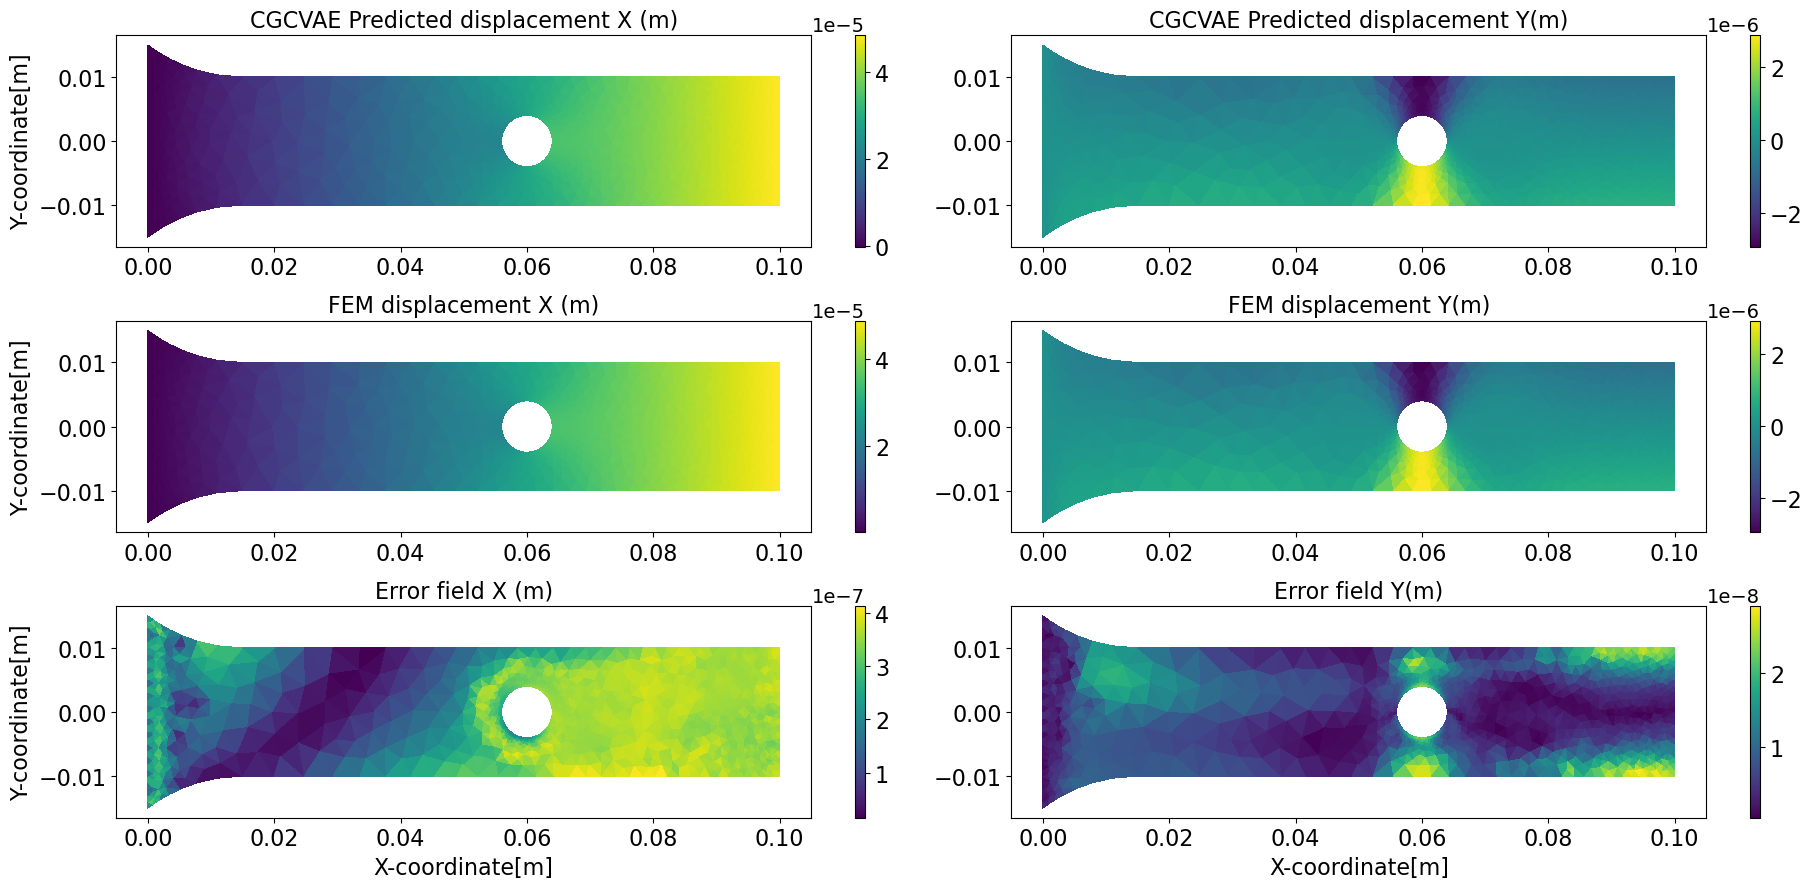

In [47]:
mesh_pos = test_sample.pos[:, :2].cpu().detach().numpy()
traiangles = test_sample.triangles.cpu().detach().numpy()
cpu_test_predict = test_predict.cpu().detach().numpy()
cpu_test_ground_truth = test_sample.x.cpu().detach().numpy()
material_params = test_sample.material_params[0].cpu().detach().numpy()
plot_result_compare_FEM(mesh_pos, traiangles, cpu_test_predict, cpu_test_ground_truth, material_params)

In [9]:
mesh_file = "/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh"
msh_data = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)
mesh_pos, node_connectivity = get_mesh(msh_data)
# ref_material_params = np.array([72.24e9, 91.69e9])
ref_material_params = np.array([7.391e+10, 8.875e+10])
# ref_material_params = test_sample.material_params[0].cpu().detach().numpy()

Info    : Reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'...
Info    : 30 entities
Info    : 1117 nodes
Info    : 2048 elements
Info    : Done reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'


In [10]:
_, _, bench_mark_ground_truth = solve_fem(msh_data, ref_material_params[0], ref_material_params[1])

In [11]:
def build_graph(mesh_pos, node_connectivity, material_params) :
    material_params = torch.tensor(material_params, dtype = torch.float32) * torch.ones(mesh_pos.shape[0], 2)
    decomposed_connectivity = triangles_to_edges(torch.tensor(node_connectivity))['two_way_connectivity']
    sender, receiver = decomposed_connectivity
    edge_index = torch.cat((sender.reshape(1, -1), receiver.reshape(1, -1)), dim=0)
    edge_features = torch.norm(mesh_pos[sender] - mesh_pos[receiver], p = 2, dim = 1).reshape(-1, 1)
    return Data(material_params = material_params, edge_index = edge_index, edge_features = edge_features, triangles = decomposed_connectivity)

In [12]:
bench_mark_input_graph = build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity), material_params = ref_material_params)

In [13]:
bench_mark_input_graph = bench_mark_input_graph.to(device)
benchmark_prediction = model.predict(bench_mark_input_graph)

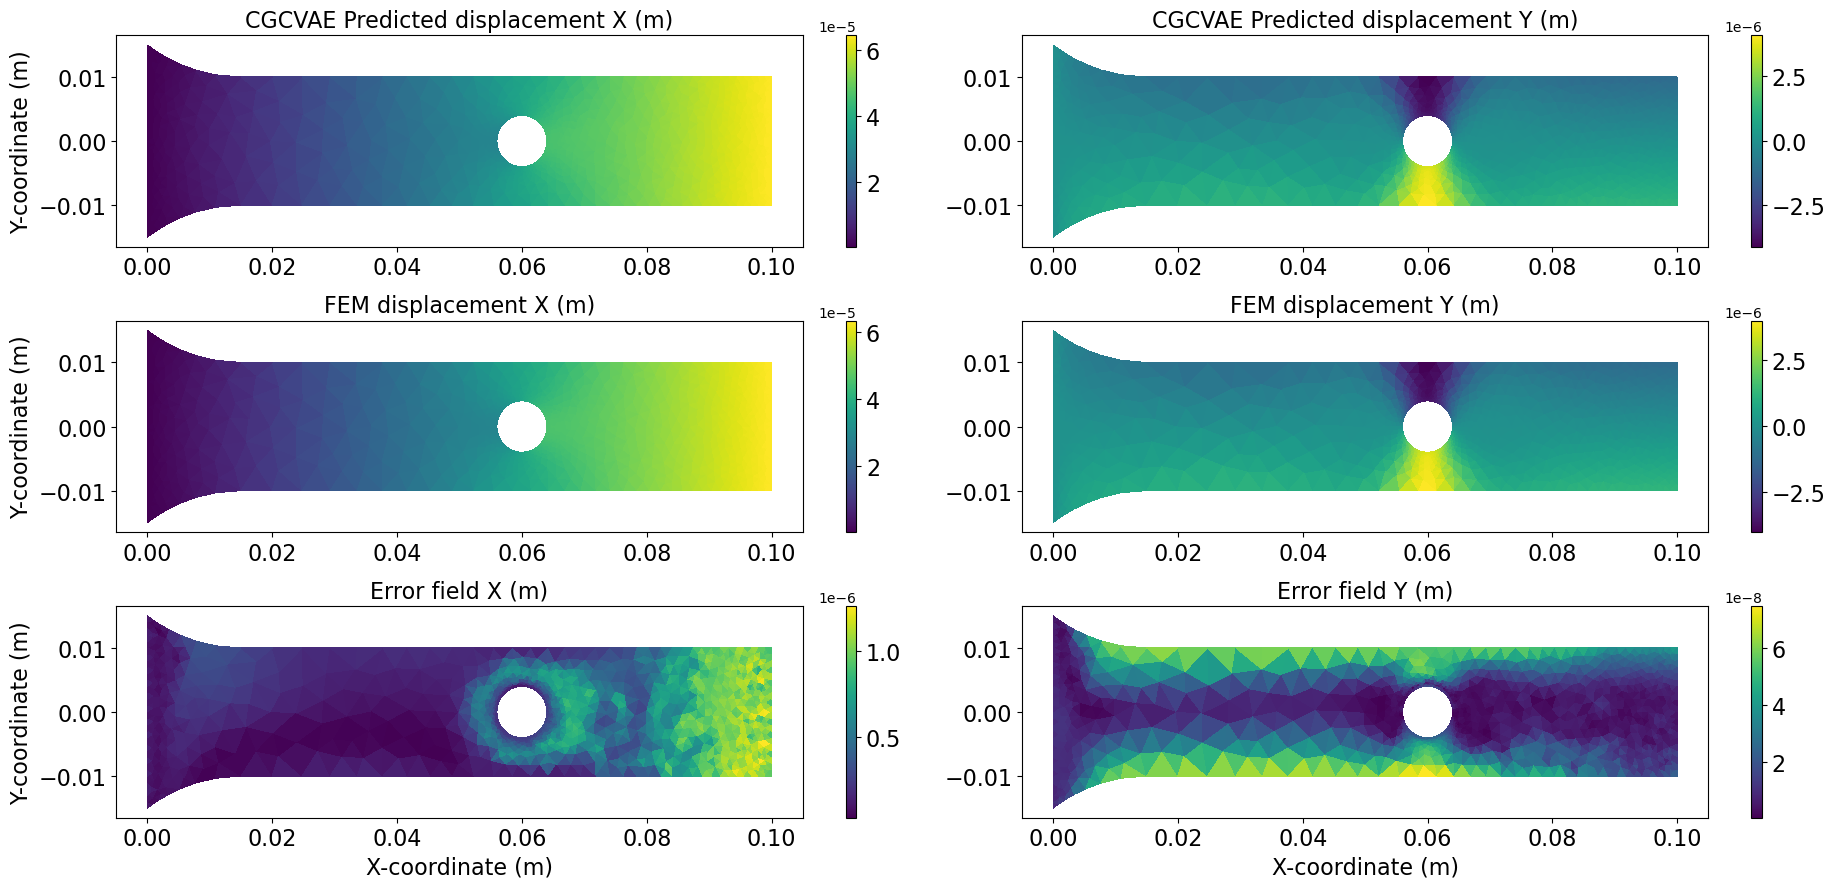

In [14]:
mesh_pos = mesh_pos
traiangles = node_connectivity
cpu_benchmark_prediction = benchmark_prediction.cpu().detach().numpy()
plot_result_compare_FEM(mesh_pos, traiangles, cpu_benchmark_prediction, bench_mark_ground_truth, ref_material_params)

In [15]:
from scipy.optimize import minimize

In [16]:
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(beta, train_ds, model, msh_data) :
    torch.manual_seed(42) 
    mesh_pos, node_connectivity = get_mesh(msh_data)
    input_graph = build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor(beta, dtype = torch.float))
    predictions = model.predict(build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor(beta, dtype = torch.float)).to(device))
    cpu_predictions = predictions.detach().cpu().numpy()
    train_disp_x = train_ds[:, 0]
    train_disp_y = train_ds[:, 1]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - cpu_predictions[:, 0]))
    err_norm_uy = np.linalg.norm(Wy * (train_disp_y - cpu_predictions[:, 1]))
    print(err_norm_ux, err_norm_uy)
    mse = (err_norm_ux**2 + err_norm_uy**2)*0.5
    # error = np.sum((cpu_predictions - train_ds)**2 , axis = 1)
    # mse = np.mean(error, axis = 0)
    print(beta, mse) 
    return mse
train_ds = bench_mark_ground_truth
history = OptimizationHistory()
beta = [1e9, 1e9]
model = model.to(device)

result = minimize(
    fun=lambda x: mse_loss(x, train_ds, model, msh_data),
    x0=beta,
    method='Nelder-Mead',
    options={'gtol': 1e-9, 'maxiter': 1000},
    callback=history
)

4.200155520429625 14.467510958214316
[1.e+09 1.e+09] 113.47508986092338
4.200052766654689 14.463168522424905
[1.05e+09 1.00e+09] 113.41184347537316
4.200153219623202 14.469386232566471
[1.00e+09 1.05e+09] 113.50221250774764
4.200055405667047 14.4612946499914
[1.05e+09 9.50e+08] 113.38475418227144
4.200007167448747 14.45724857621366
[1.075e+09 9.000e+08] 113.32604830052637
4.199899787347012 14.452886406471615
[1.125e+09 9.000e+08] 113.26254185106474
4.199768293828976 14.44555157234035
[1.1875e+09 8.5000e+08] 113.15600697549795
4.199716631743566 14.439607043992588
[1.2125e+09 7.5000e+08] 113.06993568593195
4.199536370469538 14.427770828632845
[1.29375e+09 6.25000e+08] 112.89833840522267
4.199282971373037 14.415986570552919
[1.40625e+09 5.75000e+08] 112.72732313801285
4.198887228420449 14.395182177498434
[1.571875e+09 4.125000e+08] 112.42596194018044
4.1986143029405625 14.377193167264435
[1.678125e+09 1.875000e+08] 112.16602271684611
4.197950431467442 14.34258159932298
[ 1.9234375e+09 -1.

In [17]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.10273595062723584
             x: [ 7.498e+10  9.018e+10]
           nit: 145
          nfev: 323
 final_simplex: (array([[ 7.498e+10,  9.018e+10],
                       [ 7.498e+10,  9.018e+10],
                       [ 7.498e+10,  9.018e+10]]), array([ 1.027e-01,  1.027e-01,  1.027e-01]))

In [18]:
dev_ref = np.abs((result.x - ref_material_params))/ref_material_params * 100
dev_ref

array([1.44357288, 1.60631421])

the results from the parameter identification deviate from the reference value by 0.63% and 4.31% for G and K respectively

In [20]:
optimized_G, optimized_K = result.x
b_g, b_k = np.array([7.391e+10, 8.875e+10])
# b_g, b_k = optimized_G, optimized_K


In [21]:
_, _, test_displacement = solve_fem(msh_data, b_g, b_k)

In [22]:
optimized_input_graph = build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity), material_params = np.array([optimized_G, optimized_K]))
optimized_input_graph = optimized_input_graph.to(device)
prediction = model.predict(optimized_input_graph)

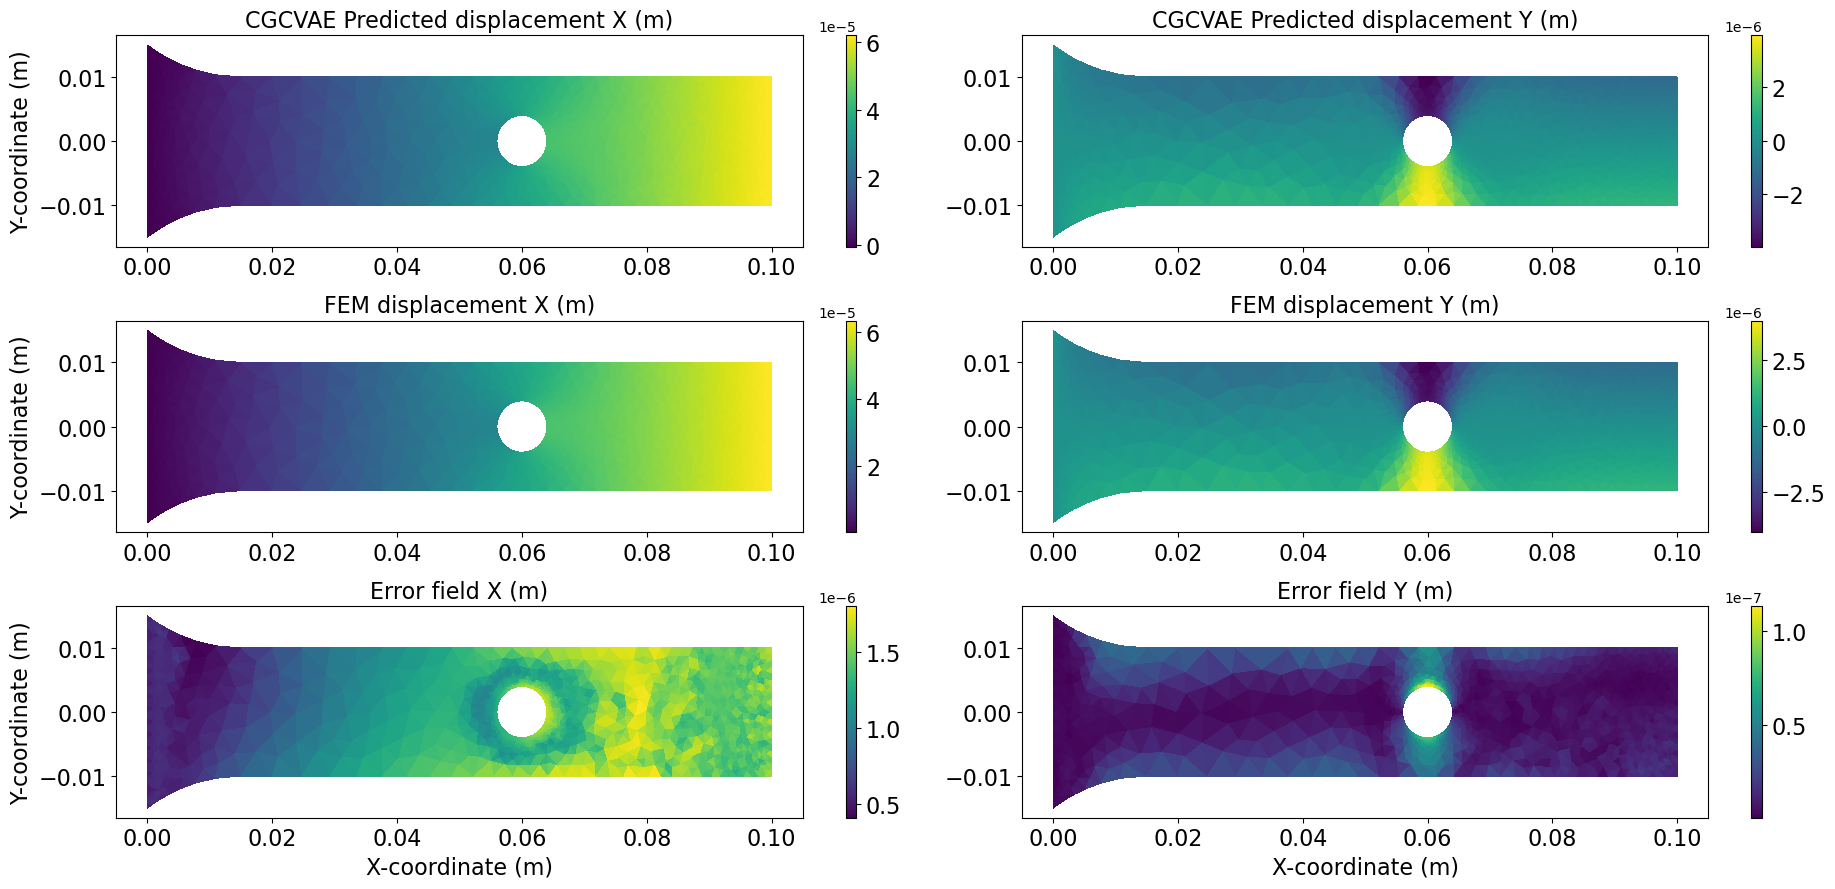

In [23]:
mesh_pos = mesh_pos
traiangles = node_connectivity
prediction = prediction.cpu().detach().numpy()
optimized_material_params = np.array([optimized_G, optimized_K])
plot_result_compare_FEM(mesh_pos, traiangles, prediction, test_displacement, optimized_material_params)

In [23]:
observed_x_0 = 20e-3
observed_y_0 = -10e-3
observed_dx = 80e-3
observed_dy = 20e-3
dry_run = model.predict(build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity), material_params = ref_material_params).to(device))
observed_mesh_pos, _ = observer_operator(mesh_pos, dry_run, observed_x_0, observed_y_0, observed_dx, observed_dy)

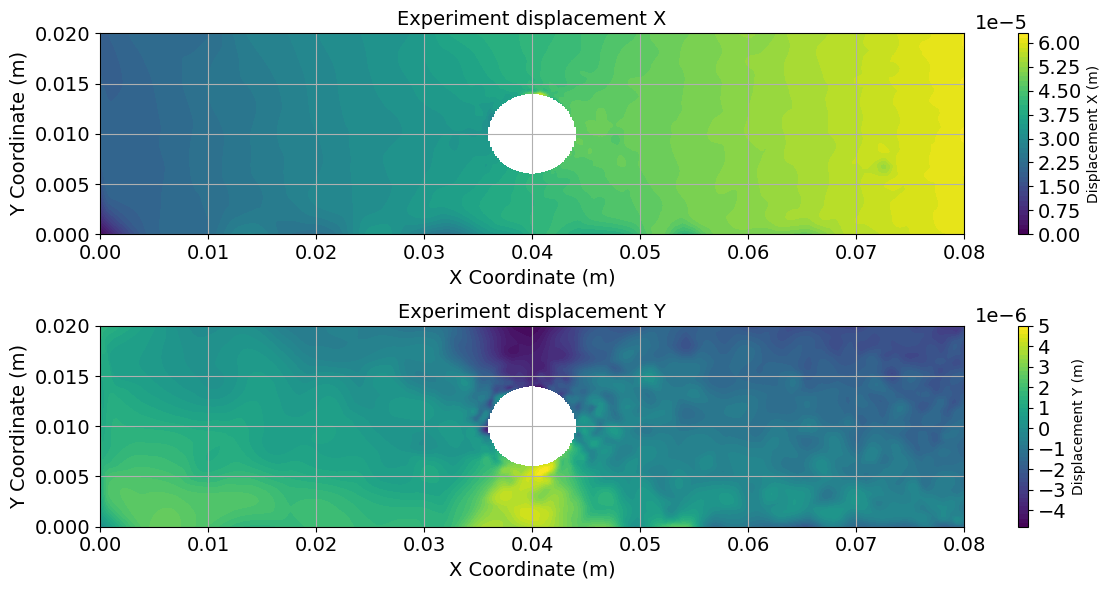

In [29]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import os
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import griddata
raw = True
if raw:
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return np.nan_to_num(flattened_image, nan = 0)

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    return interp_x, interp_y
X, Y = observed_mesh_pos[:, 0], observed_mesh_pos[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
Z_x_train = np.where(mask, Z_x, np.nan)
Z_y_train = np.where(mask, Z_y, np.nan)

# Apply mask: Set masked values to NaN
Z_x_plot = Z_x
Z_y_plot = Z_y
grid_x, grid_y = np.mgrid[np.min(X):np.max(X):500j, np.min(Y):np.max(Y):500j]
hole_center = (40e-3, 10e-3)
hole_radius = 4e-3
mask = np.sqrt((grid_x - hole_center[0])**2 + (grid_y - hole_center[1])**2) < hole_radius

# Apply mask (set values inside hole to NaN)
grid_z_x = griddata((X, Y), Z_x, (grid_x, grid_y), method='cubic')
grid_z_y = griddata((X, Y), Z_y, (grid_x, grid_y), method='cubic')
grid_z_x[mask] = np.nan
grid_z_y[mask] = np.nan
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
# Subplot for displacement_x with masked values
contour_x = ax[0].contourf(grid_x, grid_y, grid_z_x, levels=50, cmap='viridis')
contour_y = ax[1].contourf(grid_x, grid_y, grid_z_y, levels=50, cmap='viridis')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (m)')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (m)')
ax[0].set_title('Experiment displacement X', fontsize=14)
ax[0].set_xlabel('X Coordinate (m)', fontsize=14)
ax[0].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].grid(True)
ax[1].set_title('Experiment displacement Y', fontsize=14)
ax[1].set_xlabel('X Coordinate (m)', fontsize=14)
ax[1].set_ylabel('Y Coordinate (m)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].grid(True)

# Display the plots
plt.tight_layout()
pdf_filename = f'exp_field_ondiscr.pdf'
with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
    pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing
plt.show()


In [30]:
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(beta, train_ds, model, msh_data) :
    torch.manual_seed(42) 
    mesh_pos, node_connectivity = get_mesh(msh_data)
    predictions = model.predict(build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor(beta, dtype = torch.float)).to(device))
    cpu_predictions = predictions.detach().cpu().numpy()
    observed_x_0 = 20e-3
    observed_y_0 = -10e-3
    observed_dx = 80e-3
    observed_dy = 20e-3
    _, observed_displacement = observer_operator(mesh_pos, cpu_predictions, observed_x_0, observed_y_0, observed_dx, observed_dy)
    train_disp_x = train_ds[:, 2]
    train_disp_y = train_ds[:, 3]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - observed_displacement[:, 0]))
    err_norm_uy = np.linalg.norm(Wy * (train_disp_y - observed_displacement[:, 1]))
    print(err_norm_ux, err_norm_uy)
    mse = (err_norm_ux**2 + err_norm_uy**2)*0.5
    # error = np.sum((cpu_predictions - train_ds)**2 , axis = 1)
    # mse = np.mean(error, axis = 0)
    print(beta, mse) 
    return mse
history = OptimizationHistory()
beta = [1e9, 1e9]
model = model.to(device)
train_ds = np.hstack((X.reshape(X.shape[0], 1), Y.reshape(Y.shape[0], 1), Z_x.reshape(Z_x.shape[0], 1), Z_y.reshape(Z_y.shape[0], 1)))
result = minimize(
    fun=lambda x: mse_loss(x, train_ds, model, msh_data),
    x0=beta,
    method='Nelder-Mead',
    options={'gtol': 1e-20, 'maxiter': 1000},
    callback=history,
)

3.197153291873206 22.69851704366476
[1.e+09 1.e+09] 262.7222325766377
3.1976498745404633 22.697124404313293
[1.05e+09 1.00e+09] 262.6922104725113
3.1968746769589957 22.699123832498504
[1.00e+09 1.05e+09] 262.7351152316416
3.1979285979783105 22.696518020979482
[1.05e+09 9.50e+08] 262.6793387972069
3.1984557388257153 22.69521549260805
[1.075e+09 9.000e+08] 262.6514626845718
3.198947592171921 22.693817545468615
[1.125e+09 9.000e+08] 262.6213102422409
3.1998408168135337 22.691462535121495
[1.1875e+09 8.5000e+08] 262.5707266178842
3.2006389142430947 22.68954805830399
[1.2125e+09 7.5000e+08] 262.5298402747268
3.2021188494947 22.685746840009582
[1.29375e+09 6.25000e+08] 262.448337407647
3.2034875233452142 22.6819732819651
[1.40625e+09 5.75000e+08] 262.36712213800354
3.205965291634308 22.67531098673071
[1.571875e+09 4.125000e+08] 262.2239708980572
3.2081926065800297 22.669548313161876
[1.678125e+09 1.875000e+08] 262.1004602618476
3.2122654807956166 22.658491571849428
[ 1.9234375e+09 -1.4375000

In [31]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 208.00904287764985
             x: [ 7.489e+10  9.067e+10]
           nit: 162
          nfev: 351
 final_simplex: (array([[ 7.489e+10,  9.067e+10],
                       [ 7.489e+10,  9.067e+10],
                       [ 7.489e+10,  9.067e+10]]), array([ 2.080e+02,  2.080e+02,  2.080e+02]))

In [32]:
mesh_pos, node_connectivity = get_mesh(msh_data)
real_predictions = model.predict(build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor(result.x, dtype = torch.float)).to(device))
cpu_real_predictions = real_predictions.detach().cpu().numpy()
observed_x_0 = 20e-3
observed_y_0 = -10e-3
observed_dx = 80e-3
observed_dy = 20e-3
observed_mesh_pos, observed_predict_displacement = observer_operator(mesh_pos, cpu_real_predictions, observed_x_0, observed_y_0, observed_dx, observed_dy)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
from matplotlib.backends.backend_pdf import PdfPages
def plot_compare_data(obs_mesh_pos, obs_fem_disp, exp_disp):
    X, Y = obs_mesh_pos[:, 0], obs_mesh_pos[:, 1]  # Assuming FEM displacement contains X, Y coordinates
    fem_Zx, fem_Zy = obs_fem_disp[:, 0], obs_fem_disp[:, 1]  # FEM displacement X and Y
    exp_Zx, exp_Zy = exp_disp[0], exp_disp[1]  # Experimental displacement X and Y

    # Compute error fields
    error_Zx = np.abs(fem_Zx - exp_Zx)
    error_Zy = np.abs(fem_Zy - exp_Zy)

    # Define grid for interpolation
    grid_x, grid_y = np.mgrid[np.min(X):np.max(X):500j, np.min(Y):np.max(Y):500j]

    # Define hole region (e.g., circular hole at center)
    hole_center = (40e-3, 10e-3)
    hole_radius = 4e-3
    mask = np.sqrt((grid_x - hole_center[0])**2 + (grid_y - hole_center[1])**2) < hole_radius

    # Interpolate values onto a structured grid
    grid_fem_Zx = griddata((X, Y), fem_Zx, (grid_x, grid_y), method='cubic')
    grid_fem_Zy = griddata((X, Y), fem_Zy, (grid_x, grid_y), method='cubic')
    grid_exp_Zx = griddata((X, Y), exp_Zx, (grid_x, grid_y), method='cubic')
    grid_exp_Zy = griddata((X, Y), exp_Zy, (grid_x, grid_y), method='cubic')
    grid_error_Zx = griddata((X, Y), error_Zx, (grid_x, grid_y), method='cubic')
    grid_error_Zy = griddata((X, Y), error_Zy, (grid_x, grid_y), method='cubic')

    # Apply mask to remove hole region
    for grid in [grid_fem_Zx, grid_fem_Zy, grid_exp_Zx, grid_exp_Zy, grid_error_Zx, grid_error_Zy]:
        grid[mask] = np.nan

    # Create figure and axis
    fig, ax = plt.subplots(3, 2, figsize=(20, 8))  # 3 Rows, 2 Columns

    # Titles for rows and columns
    row_titles = ["CGCVAE Predicted displacement", "Experiment displacement", "Error Field"]
    col_titles = ["X (m)", "Y (m)"]

    # Data to plot
    grids = [[grid_fem_Zx, grid_fem_Zy], 
             [grid_exp_Zx, grid_exp_Zy], 
             [grid_error_Zx, grid_error_Zy]]

    # Plot each subplot
    for i in range(3):  # Rows
        for j in range(2):  # Columns
            contour = ax[i, j].contourf(grid_x, grid_y, grids[i][j], levels=50, cmap='viridis')
            cbar = fig.colorbar(contour, ax=ax[i, j])
            cbar.ax.tick_params(labelsize=16)
            
            # Set labels and titles
            ax[i, j].set_title(f"{row_titles[i]} {col_titles[j]}", fontsize=16)
            if i == 2 :
                ax[i, j].set_xlabel("X Coordinate (m)", fontsize=16)
            if j == 0 :
                ax[i, j].set_ylabel("Y Coordinate (m)", fontsize=16)
            ax[i, j].tick_params(axis='both', labelsize=16)
            ax[i, j].grid(True)

    # Adjust layout
    plt.tight_layout()
    pdf_filename = f'prediction_vs_exp.pdf'
    with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
        pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing

    plt.show()


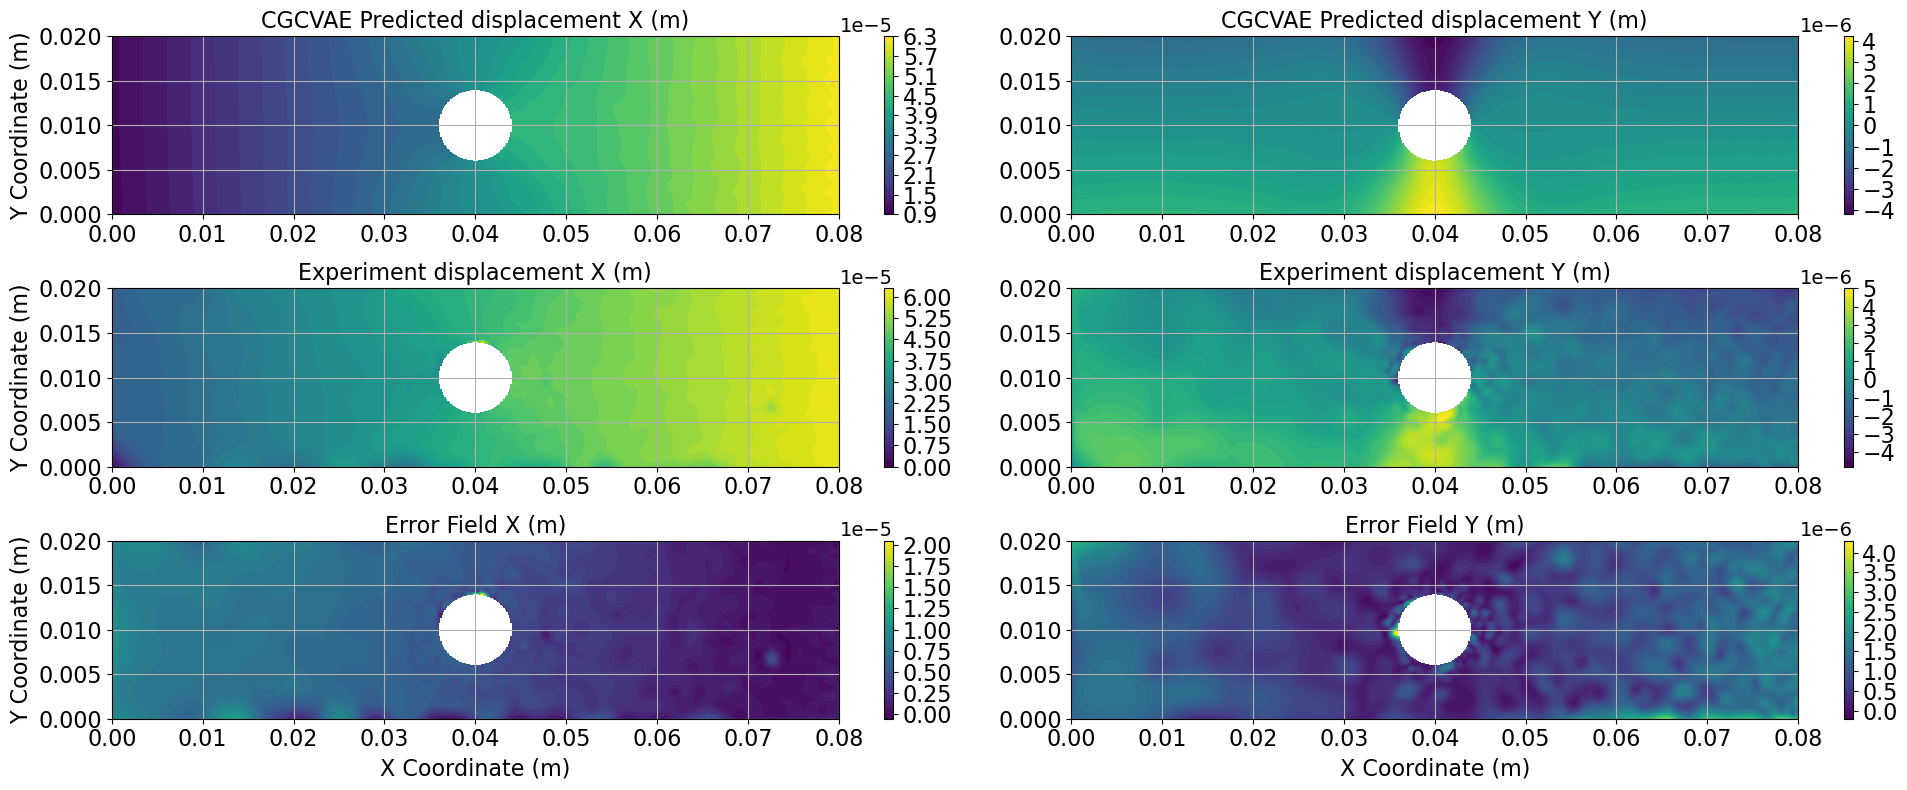

In [54]:
plot_compare_data(observed_mesh_pos, observed_predict_displacement, [train_ds[:,2], train_ds[:,3]])

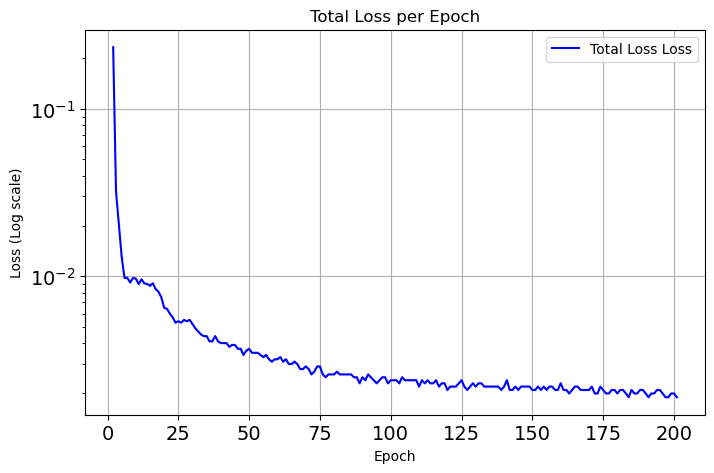

In [31]:
import re
import matplotlib.pyplot as plt

def read_loss_from_file(filename):
    epochs = []
    losses = []
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(r'Epoch (\d+)/\d+, loss: ([\d\.]+)', line)
            if match:
                epoch = int(match.group(1))
                loss = float(match.group(2))
                epochs.append(epoch)
                losses.append(loss)
    
    return epochs, losses

def plot_loss(epochs, losses):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5)) 
    # plt.figure(figsize=(8, 5))
    ax.plot(epochs, losses, marker='o', linestyle='-', color='b', markersize = 0.1, label='Total Loss Loss')
    ax.set_yscale('log')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Log scale)')
    ax.set_title('Total Loss per Epoch')
    ax.legend()
    ax.grid()
    pp = PdfPages(f'training_loss.pdf')
    pp.savefig(fig)
    pp.close()
    plt.show()

if __name__ == "__main__":
    filename = "/home/narupanta/ADDMM/ADDMM/surrogate_model/output/2025-02-06T22h18m00s/logs/logs.txt"  # Change to your file name
    epochs, losses = read_loss_from_file(filename)
    if epochs and losses:
        plot_loss(epochs, losses)
    else:
        print("No valid data found in the file.")


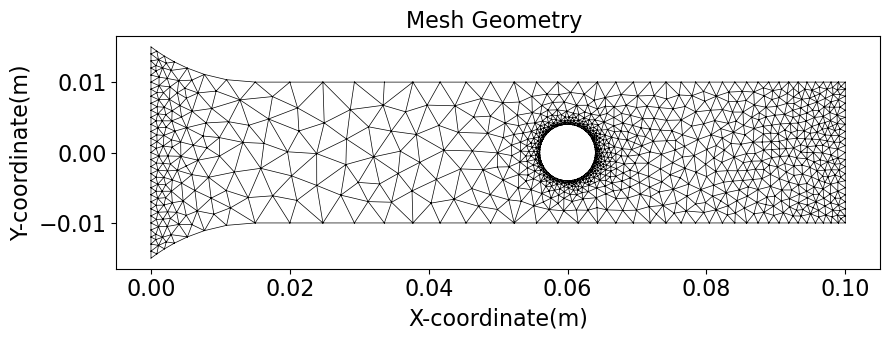

In [36]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def plot_geometry_mesh(mesh_pos, triangles):
    # Get node coordinates
    nodes = mesh_pos  

    # Triangulation for mesh
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

    # Create subplots with 3 rows and 2 columns
    fig, axes = plt.subplots(1, 1, figsize=(9, 3.5))  

    # Set font sizes
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 16

    # Iterate over data fields

    # Plot the field
    # im = axes[row][col].tripcolor(triangulation, v[:, j], shading='flat', cmap='viridis')
    axes.triplot(triangulation, color='black', linewidth=0.5)

            # Set title
    axes.set_title(f"Mesh Geometry ", fontsize=title_fontsize)

            # Display X-axis label only for the last row (row == 2)
    axes.set_xlabel("X-coordinate(m)", fontsize=label_fontsize)

            # Display Y-axis label only for the left column (col == 0)
    axes.set_ylabel("Y-coordinate(m)", fontsize=label_fontsize)

            # Adjust tick label sizes
    axes.tick_params(axis='both', labelsize=tick_fontsize)

    # Add colorbar

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save to PDF
    pdf_filename = f'geometry_mesh.pdf'
    with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
        pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing

    # Show the plot
    plt.show()
plot_geometry_mesh(mesh_pos, traiangles)


In [25]:
mesh_pos.shape

(1117, 2)

In [26]:
traiangles.shape

(1998, 3)

In [ ]:
mesh_pos = test_sample.pos[:, :2].cpu().detach().numpy()
traiangles = test_sample.triangles.cpu().detach().numpy()
cpu_test_predict = test_predict.cpu().detach().numpy()
cpu_test_ground_truth = test_sample.x.cpu().detach().numpy()
material_params = test_sample.material_params[0].cpu().detach().numpy()
plot_result_compare_FEM(mesh_pos, traiangles, cpu_test_predict, cpu_test_ground_truth, material_params)